<a href="https://colab.research.google.com/github/multikokoiti1998/vgg_8_3/blob/VGG16/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install albumentations

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
from tqdm import tqdm
import random
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision
from PIL import Image
import torch.nn as nn
import torch
import pandas as pd
from sklearn.model_selection import KFold,train_test_split,StratifiedKFold
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Tuple
from pathlib import Path
import xml.etree.ElementTree as ET
import torchvision.models as models
import torch.optim as optim
import albumentations as A
from sklearn.metrics import classification_report

In [4]:
# 画像ディレクトリと画像パスの取得
image_directory = '/content/drive/MyDrive/lernig/obiref88/image'
label_directory = '/content/drive/MyDrive/lernig/obiref88/label'

def update_xml_paths(image_directory: str, label_directory: str):
    image_paths = []
    labels = []

    # 画像ファイルとXMLファイルの一致確認
    for image_file in os.listdir(image_directory):
        if image_file.endswith('.jpg'):
            base_name = image_file.replace('.jpg', '')

            xml_path = Path(label_directory) / f"{base_name}.xml"

            if xml_path.exists():
                tree = ET.parse(xml_path)
                root = tree.getroot()
                label = root.find('.//name')
                image_paths.append(os.path.join(image_directory, image_file))
                labels.append(label.text)

    return image_paths, labels

image_paths, labels = update_xml_paths(image_directory, label_directory)
print("Number of image paths:", len(image_paths))
print("Number of labels:", len(labels))


Number of image paths: 300
Number of labels: 300


In [5]:
data_transform = {
    'train': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
         transforms.RandomRotation(degrees=[-5, 5]),
         transforms.ColorJitter(brightness=0.3, contrast=0.5),
         #A.GaussNoise(var_limit=(10, 50))transformライブラリでないので変換前後で定義しなおさなくてはならない,
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ]),
    'val': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ])
}



In [6]:
label_mapping = {
    'ok': 0,
    'out': 1
}
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = [label_mapping[label] for label in labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
            label=torch.tensor(label)
        return image, label


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
num_epochs=200
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_dataset=[]
val_dataset=[]
total_train_accs=[]
total_val_accs=[]
data_size = {'train': len(train_dataset), 'val': len(val_dataset)}

In [9]:
def train_model(model, criterion, optimizer, num_epochs):

        for epoch in range(num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / data_size[phase]
                epoch_acc = corrects.double() / data_size[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

              #print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        train_accs_cpu = [acc.cpu().numpy() for acc in train_accs]
        val_accs_cpu = [acc.cpu().numpy() for acc in val_accs]

        plot_training_history(train_losses, val_losses, train_accs_cpu, val_accs_cpu)



def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    # Lossのプロット
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracyのプロット
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.4, 1)
    plt.tight_layout()
    plt.show()


In [10]:
net = models.vgg16(pretrained=True)

#for param in net.parameters():
          #param.requires_grad = False

# モデルをGPUに移動

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# 損失関数と最適化アルゴリズムを定義(MSE）
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
# モデルのトレーニングと評価
model = net
base_path = r'/content/drive/MyDrive/learning'
folder_name = 'weight'
directory_path = os.path.join(base_path, folder_name)
file_name = 'alexnet.pth'
file_path = os.path.join(base_path, folder_name, file_name)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 225MB/s]


In [11]:
print("Length of image_paths:", len(image_paths))
print("Length of labels:", len(labels))

Length of image_paths: 300
Length of labels: 300


==========Cross Validation Fold 1==========
trainLoss: 4.5042 Acc: 0.3333
valLoss: 1.9511 Acc: 0.2333
trainLoss: 0.9542 Acc: 0.6625
valLoss: 0.6106 Acc: 0.7667
trainLoss: 0.8046 Acc: 0.7250
valLoss: 0.8334 Acc: 0.5833
trainLoss: 0.6382 Acc: 0.7375
valLoss: 0.4239 Acc: 0.8333
trainLoss: 0.5286 Acc: 0.7875
valLoss: 0.7651 Acc: 0.6167
trainLoss: 0.5766 Acc: 0.7875
valLoss: 0.5284 Acc: 0.8000
trainLoss: 0.6559 Acc: 0.7458
valLoss: 0.7360 Acc: 0.6667
trainLoss: 0.5007 Acc: 0.7792
valLoss: 0.3360 Acc: 0.9000
trainLoss: 0.5523 Acc: 0.7750
valLoss: 0.3532 Acc: 0.8500
trainLoss: 0.4831 Acc: 0.8208
valLoss: 0.3589 Acc: 0.8500
trainLoss: 0.4553 Acc: 0.8167
valLoss: 0.5294 Acc: 0.7500
trainLoss: 0.4497 Acc: 0.8250
valLoss: 0.2873 Acc: 0.9000
trainLoss: 0.4399 Acc: 0.8500
valLoss: 0.6171 Acc: 0.7333
trainLoss: 0.5317 Acc: 0.7708
valLoss: 0.4045 Acc: 0.8167
trainLoss: 0.5086 Acc: 0.7833
valLoss: 0.2820 Acc: 0.8833
trainLoss: 0.4248 Acc: 0.8417
valLoss: 0.3733 Acc: 0.8167
trainLoss: 0.4406 Acc: 0.812

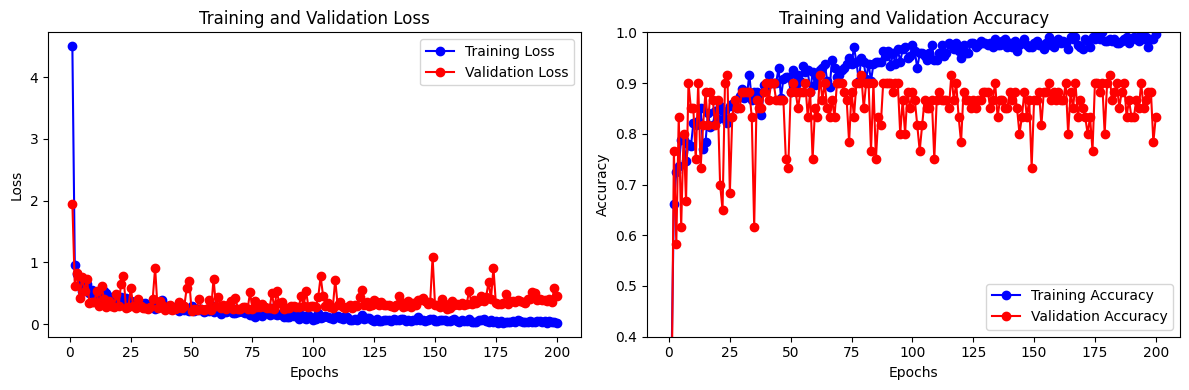

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.93      0.85      0.89        47
         out       0.59      0.77      0.67        13

    accuracy                           0.83        60
   macro avg       0.76      0.81      0.78        60
weighted avg       0.86      0.83      0.84        60

==========Cross Validation Fold 2==========
trainLoss: 0.1511 Acc: 0.9667
valLoss: 0.0450 Acc: 0.9667
trainLoss: 0.1828 Acc: 0.9167
valLoss: 0.2906 Acc: 0.8333
trainLoss: 0.1998 Acc: 0.9417
valLoss: 0.2801 Acc: 0.8667
trainLoss: 0.1892 Acc: 0.9292
valLoss: 0.0311 Acc: 0.9833
trainLoss: 0.1138 Acc: 0.9625
valLoss: 0.0531 Acc: 0.9667
trainLoss: 0.1268 Acc: 0.9417
valLoss: 0.0167 Acc: 1.0000
trainLoss: 0.0883 Acc: 0.9750
valLoss: 0.0122 Acc: 1.0000
trainLoss: 0.1002 Acc: 0.9667
valLoss: 0.0079 Acc: 1.0000
trainLoss: 0.0852 Acc: 0.9667
valLoss: 0.0118 Acc: 1.0000
trainLoss: 0.0468 Acc: 0.9917
valLoss: 0.0077 Acc: 1.0000
trainLoss: 0.1268 Acc: 0

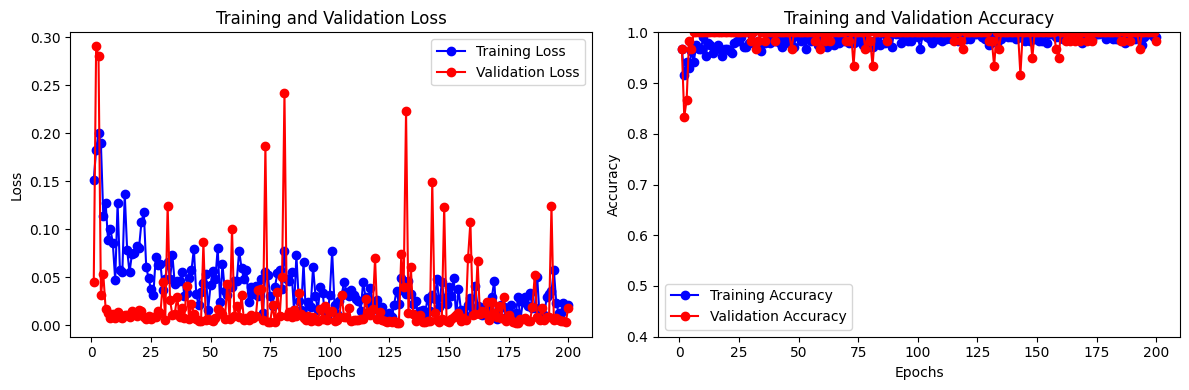

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.98      1.00      0.99        48
         out       1.00      0.92      0.96        12

    accuracy                           0.98        60
   macro avg       0.99      0.96      0.97        60
weighted avg       0.98      0.98      0.98        60

==========Cross Validation Fold 3==========
trainLoss: 0.0162 Acc: 0.9958
valLoss: 0.0420 Acc: 0.9833
trainLoss: 0.0214 Acc: 0.9917
valLoss: 0.2730 Acc: 0.9167
trainLoss: 0.0406 Acc: 0.9917
valLoss: 0.0182 Acc: 0.9833
trainLoss: 0.0210 Acc: 0.9917
valLoss: 0.0446 Acc: 0.9667
trainLoss: 0.0147 Acc: 0.9958
valLoss: 0.0434 Acc: 0.9833
trainLoss: 0.0332 Acc: 0.9875
valLoss: 0.0773 Acc: 0.9667
trainLoss: 0.0141 Acc: 1.0000
valLoss: 0.0767 Acc: 0.9667
trainLoss: 0.0159 Acc: 0.9958
valLoss: 0.0650 Acc: 0.9833
trainLoss: 0.0071 Acc: 1.0000
valLoss: 0.0656 Acc: 0.9833
trainLoss: 0.0178 Acc: 0.9917
valLoss: 0.0896 Acc: 0.9667
trainLoss: 0.0157 Acc: 0

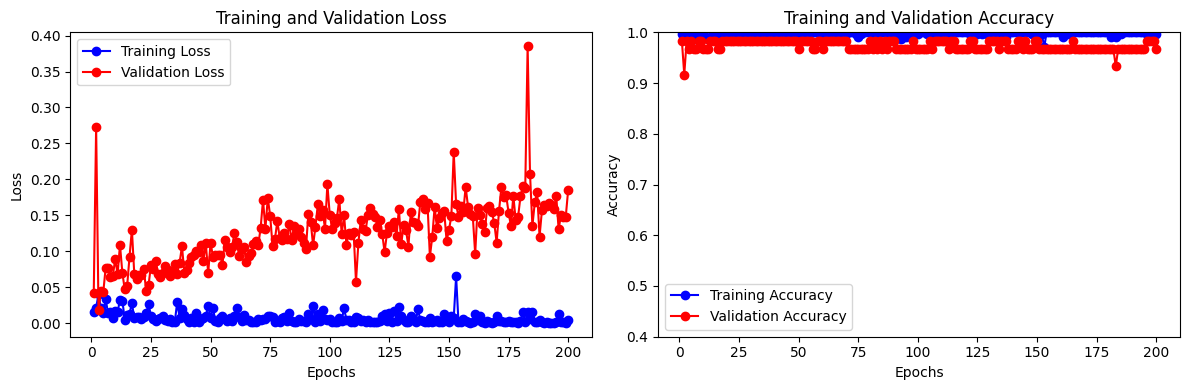

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       1.00      0.95      0.98        42
         out       0.90      1.00      0.95        18

    accuracy                           0.97        60
   macro avg       0.95      0.98      0.96        60
weighted avg       0.97      0.97      0.97        60

==========Cross Validation Fold 4==========
trainLoss: 0.0984 Acc: 0.9875
valLoss: 0.0006 Acc: 1.0000
trainLoss: 0.0364 Acc: 0.9833
valLoss: 0.0012 Acc: 1.0000
trainLoss: 0.0124 Acc: 0.9958
valLoss: 0.0017 Acc: 1.0000
trainLoss: 0.0326 Acc: 0.9917
valLoss: 0.0009 Acc: 1.0000
trainLoss: 0.0186 Acc: 0.9958
valLoss: 0.0047 Acc: 1.0000
trainLoss: 0.0138 Acc: 0.9958
valLoss: 0.0013 Acc: 1.0000
trainLoss: 0.0315 Acc: 0.9875
valLoss: 0.0262 Acc: 0.9667
trainLoss: 0.0407 Acc: 0.9833
valLoss: 0.0024 Acc: 1.0000
trainLoss: 0.0180 Acc: 0.9958
valLoss: 0.0009 Acc: 1.0000
trainLoss: 0.0262 Acc: 0.9917
valLoss: 0.0034 Acc: 1.0000
trainLoss: 0.0270 Acc: 0

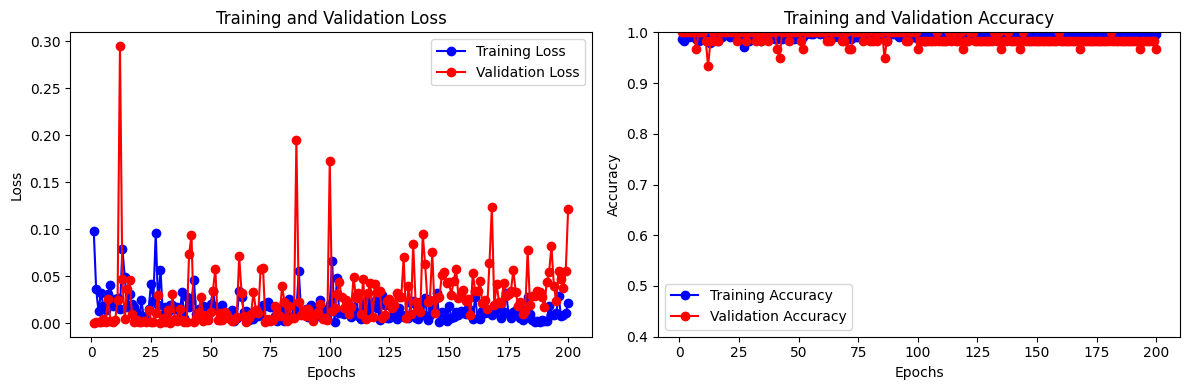

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.96      1.00      0.98        44
         out       1.00      0.88      0.93        16

    accuracy                           0.97        60
   macro avg       0.98      0.94      0.96        60
weighted avg       0.97      0.97      0.97        60

==========Cross Validation Fold 5==========
trainLoss: 0.0184 Acc: 0.9958
valLoss: 0.0010 Acc: 1.0000
trainLoss: 0.0139 Acc: 0.9958
valLoss: 0.0008 Acc: 1.0000
trainLoss: 0.0200 Acc: 0.9875
valLoss: 0.0134 Acc: 1.0000
trainLoss: 0.0203 Acc: 0.9875
valLoss: 0.0017 Acc: 1.0000
trainLoss: 0.0134 Acc: 0.9917
valLoss: 0.0059 Acc: 1.0000
trainLoss: 0.0041 Acc: 1.0000
valLoss: 0.0025 Acc: 1.0000
trainLoss: 0.0155 Acc: 0.9917
valLoss: 0.0031 Acc: 1.0000
trainLoss: 0.0115 Acc: 0.9917
valLoss: 0.0033 Acc: 1.0000
trainLoss: 0.0284 Acc: 0.9917
valLoss: 0.0222 Acc: 0.9833
trainLoss: 0.0285 Acc: 0.9917
valLoss: 0.0056 Acc: 1.0000
trainLoss: 0.0103 Acc: 1

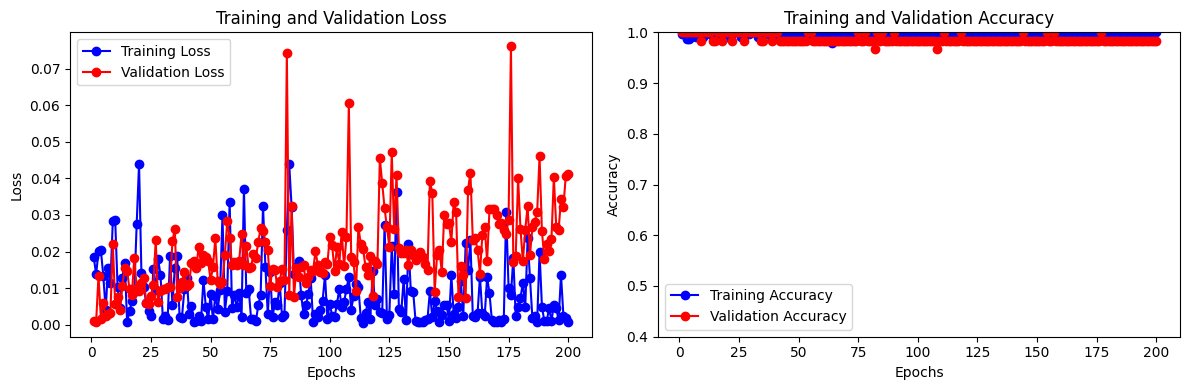

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.98      1.00      0.99        45
         out       1.00      0.93      0.97        15

    accuracy                           0.98        60
   macro avg       0.99      0.97      0.98        60
weighted avg       0.98      0.98      0.98        60



In [13]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# データセットの分割とデータローダーの作成
for fold, (train_index, val_index) in enumerate(kfold.split(image_paths,labels), 1):
    print(f'==========Cross Validation Fold {fold}==========')
    image_directory = '/content/drive/MyDrive/lernig/OBI_ref/image'
    label_directory = '/content/drive/MyDrive/lernig/OBI_ref/label'


    image_paths, labels = update_xml_paths(image_directory, label_directory)
    train_paths = [image_paths[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = [labels[i] for i in val_index]

    train_dataset = ImageDataset(train_paths, train_labels, transform=data_transform['train'])
    val_dataset = ImageDataset(val_paths, val_labels, transform=data_transform['val'])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    dataloaders  = {"train":train_loader, "val":val_loader}

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # 事前学習済みモデルの全結合層の出力ユニット数をデータのクラス数に置き換え
    num_classes = len(set(train_labels))
    net.fc = nn.Linear(4096, num_classes)

# ここでデータローダーを使用して学習や検証を行う
    data_size = {'train': len(train_dataset), 'val': len(val_dataset)}
    train_model(model, criterion, optimizer, num_epochs)
    print('Train done.')
    file_path = os.path.join(directory_path, f'{file_name}_{str(fold)}.pth')
    # モデルの保存
    torch.save(model.state_dict(), file_path)
    print('Train saved.')
    model.load_state_dict(torch.load(file_path))
    model.eval()
    model.to(device)

    y_pred = []
    y_true = []
    with torch.no_grad():
      for images, labels in val_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())

    # 評価
    target_names = ['ok', 'out']  # クラス名をリストで指定
    print(classification_report(y_true, y_pred, target_names=target_names))